In [280]:
import geopandas as gpd
import folium
import saxpy 
import os
import pyproj
import substation_analysis_functions 
from imp import reload
reload(substation_analysis_functions)


<module 'substation_analysis_functions' from '/Users/Orie4416/Desktop/Energy Systems RAship/LEO/leo_substation_analysis/substation_analysis_functions.py'>

# Pre-Process Data in one run

In [ ]:



# Define the folder path
folder_path = "../Substation Busbar Data/"

# Create an empty dictionary to store the dataframes
dataframes = {}

# Iterate through all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV file
    if file_name.endswith(".csv"):
        print(file_name, '\n')
        # Extract the substation name from the file name
        substation_name = file_name.split(" ")[2:]
        substation_name = substation_name[:substation_name.index("POWER")]
        substation_name = " ".join(substation_name)
        
        # Read the CSV file into a pandas dataframe
        df = pd.read_csv(os.path.join(folder_path, file_name))
        # Convert date column to datetime -- using this as opportunity to skip over empty dataframes (if you don't want this, add "errors = 'ignore'" to the to_datetime command)
        try:
            df['Datetime'] = pd.to_datetime(df['Date (Dublin. Edinburgh. Lisbon. London)'], format = '%d/%m/%Y %H:%M:%S') 
        except TypeError:
            df['Datetime'] = pd.to_datetime(df['Date (Dublin. Edinburgh. Lisbon. London)'])
        
        # Drop old date column 
        df.drop('Date (Dublin. Edinburgh. Lisbon. London)', axis=1, inplace=True)
        # Add the dataframe to the dictionary with the substation ID as the key
        dataframes[substation_name] = df

# Print the dataframe keys to check that the IDs processed appropriately
print(dataframes.keys())


empty_substations = []
for substation, df in dataframes.items():
    if df.isna().sum().sum() > 0:
        empty_substations.append(substation)

if not empty_substations:
    print("No missing values")



########################################################################
### Drop substations with less than 50% available active power data ####
########################################################################
threshold = 0.50 # 50% threshold
substations_below_threshold = []
for substation, df in dataframes.items():
    count_zero = (df['Active Power [kW]'] == 0).sum()
    if count_zero > (len(df) * threshold):
        substations_below_threshold.append(substation)
        
for substation in substations_below_threshold:
    print(f"Substation {substation} has less than 50% available active power data. Dropping from dataframe.")
    del dataframes[substation]
    
    
def detect_bad_power_values(df, active_upper_threshold = 700, active_lower_threshold = 0, reactive_upper_threshold = 250, reactive_lower_threshold = -100):
    # Find Active Power values over 1500 kW
    bad_vals = df[(df['Active Power [kW]'] > active_upper_threshold) | (df['Active Power [kW]'] < active_lower_threshold) | (df['Reactive Power [kVAr]'] > reactive_upper_threshold) | (df['Reactive Power [kVAr]'] < reactive_lower_threshold)]
    
    drop_dates = bad_vals['Datetime'].dt.date.unique()

    df = df[~df['Datetime'].dt.date.isin(drop_dates)]
    
    return df 
    
for substation, df in dataframes.items():
    dataframes[substation] = detect_bad_power_values(df)
        
    
    
    
    
def split_by_season(df):
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df['Month'] = df['Datetime'].dt.month
    
    spring = df[(df['Month'] >= 3) & (df['Month'] <= 5)]
    summer = df[(df['Month'] >= 6) & (df['Month'] <= 8)]
    fall = df[(df['Month'] >= 9) & (df['Month'] <= 11)]
    winter = df[(df['Month'] == 12) | ((df['Month'] >= 1) & (df['Month'] <= 2))]
    
    return spring, summer, fall, winter

substation_dataframes = {}
for substation, df in dataframes.items():
    spring, summer, fall, winter = split_by_season(df)
    substation_dataframes[substation] = {'spring': spring, 'summer': summer, 'fall': fall, 'winter': winter}
    
    
    
# Split seasonal dataframes into week and week-end dataframes
def split_weekend_week(df):
    df['weekday'] = df['Datetime'].dt.weekday
    week_df = df[df['weekday'].isin([0,1,2,3,4])]
    weekend_df = df[df['weekday'].isin([5,6])]
    return week_df, weekend_df

chopped_substation_dfs = {}
for substation, season_dict in substation_dataframes.items():
    chopped_substation_dfs[substation] = {}
    for season, df in season_dict.items():
        week_df, weekend_df = split_weekend_week(df)
        chopped_substation_dfs[substation][season] = {}
        chopped_substation_dfs[substation][season]['week'] = week_df
        chopped_substation_dfs[substation][season]['weekend'] = weekend_df
        
        
# Drop substations with not enough data in sub-set
drop_list = []
for substation, seasons in chopped_substation_dfs.items():
    for season, days in seasons.items():
        for time_of_week, df in days.items():
            days_with_data = len(df['Datetime'].dt.date.unique())
            if time_of_week == 'week':
                if days_with_data < 33: # 33 days is ~1/2 of the 65 days in a season during the week 
                    print(f"Substation {substation} has only {days_with_data} days of data in {season} {time_of_week} (<~1/2 of what should be there). Dropping from analysis.")
                    drop_list.append(str(substation) + "_" + str(season) + "_" + str(time_of_week))
            else:
                if days_with_data < 13: #(has less than half of weekends)
                    print(f'Substation {substation} has only {days_with_data} days of data in {season} {time_of_week} (<~1/2 of what should be there). Dropping from analysis.')
                    drop_list.append(str(substation) + "_" + str(season) + "_" + str(time_of_week))
           # print(substation, season, time_of_week, len(df))
           
           
           
print("number of sub-datasets to drop,", len(drop_list))
for to_drop in drop_list:
    substation = to_drop.split("_")[0]
    season = to_drop.split("_")[1]
    time_of_week = to_drop.split("_")[2]
    del chopped_substation_dfs[substation][season][time_of_week]
    
    
    
'''
Same as v2, but option to get reactive power features as well as active power features
'''

def extract_global_features_v3(substation, df, active = True):
    # convert datetime column to datetime type
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    
    df['Date'] = df['Datetime'].dt.date
    df['Hour'] = df['Datetime'].dt.hour
    
    # set datetime column as index
    df = df.set_index('Datetime')
    
    first = True
    for feature_of_interest in ['Active Power [kW]', 'Reactive Power [kVAr]']:
        
    # # Set feature of interest to either active or reactive power
    # if active:
    #     feature_of_interest = 'Active Power [kW]'
    #     # group data by day to extract any staistical features across all days
        
    # else:
    #     feature_of_interest = 'Reactive Power [kVAr]'
    #     # if reactive power, group data by positive and negative and then by day 

        ##################################################################
        ##################################################################
        
        # group data by day to get daily load pattern (total energy consumed in a day)
        daily_groups = df.groupby(df['Date'])
        
        # Mean daily power consumption 
        mean_powers = daily_groups[feature_of_interest].mean()
        
        # Std deviation of daily power consumption
        sd_powers = daily_groups[feature_of_interest].std()
        
        # Max power consumption during a day
        max_powers = daily_groups[feature_of_interest].max()
        
        # Min power consumption during a day
        min_powers = daily_groups[feature_of_interest].min()
        
        # Range of power consumption during a day
        range_powers = max_powers - min_powers
        
        # Percent values above mean value in each day
        above_mean_counts = [(df[(df['Date'] == date) & (df[feature_of_interest] > mean)]).shape[0] for date, mean in mean_powers.iteritems()]
        percentage_above_mean = [above_mean_count / 24 * 100 for i, above_mean_count in enumerate(above_mean_counts)]

        # Filter the dataframe to include only the hours between 9 and 17
        filtered_business_hours = df[(df['Hour'] >= 9) & (df['Hour'] <= 18)]
        # Group by date
        grouped_business_hours = filtered_business_hours.groupby(by=['Date'])
        # Sum of net loads during business hours (9am-6pm)
        business_hour_loads = grouped_business_hours[feature_of_interest].sum()
        
        ####################### Now for non-business hours (the opposite) #############################
        filtered_non_business_hours = df[(df['Hour'] < 9) | (df['Hour'] > 18)]
        grouped_non_business_hours = filtered_non_business_hours.groupby(by=['Date'])
        non_business_hour_loads = grouped_non_business_hours[feature_of_interest].sum()
        
        # Skewness 
        skewness_daily_load_pattern = daily_groups[feature_of_interest].sum().skew()
        
        # Kurtosis 
        kurtosis_daily_load_pattern = daily_groups[feature_of_interest].sum().kurtosis()
        
        # Mode of 5-bin histogram for daily load pattern
        hist, bin_edges = np.histogram(daily_groups[feature_of_interest].sum(), bins=5)
        mode_5_bin_histogram = bin_edges[np.argmax(hist)]
        
        if first:
            features = {
                f'Mean value of daily load pattern (kW) {feature_of_interest}' : mean_powers.mean(),
                f'SD of daily load pattern (kW) {feature_of_interest}': sd_powers.mean(),
                f'Max power consumption during a day (kW) {feature_of_interest}': max_powers.max(),
                f'Min power consumption during a day (kW) {feature_of_interest}': min_powers.min(),
                f'Range of power consumption during a day (max - min) (kW) {feature_of_interest}': range_powers.max(),
                f'Percent values above mean val (%) {feature_of_interest}': statistics.mean(above_mean_counts),
                f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}': business_hour_loads.mean(),
                f'Sum of net loads during non-business hours {feature_of_interest}': non_business_hour_loads.mean(),
                f'Skewness of the distribution of a daily load pattern {feature_of_interest}': skewness_daily_load_pattern.mean(),
                f'Kurtosis of distribution of a daily load pattern {feature_of_interest}': kurtosis_daily_load_pattern.mean(),
                f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}': mode_5_bin_histogram
                #'Longest sub-sequence where consecutive value above mean value': longest_subseq_above_mean,
            # 'Longest period of successive increases': longest_period_successive_increases
            }
        else:
            next = {
                f'Mean value of daily load pattern (kW) {feature_of_interest}' : mean_powers.mean(),
                f'SD of daily load pattern (kW) {feature_of_interest}': sd_powers.mean(),
                f'Max power consumption during a day (kW) {feature_of_interest}': max_powers.max(),
                f'Min power consumption during a day (kW) {feature_of_interest}': min_powers.min(),
                f'Range of power consumption during a day (max - min) (kW) {feature_of_interest}': range_powers.max(),
                f'Percent values above mean val (%) {feature_of_interest}': statistics.mean(above_mean_counts),
                f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}': business_hour_loads.mean(),
                f'Sum of net loads during non-business hours {feature_of_interest}': non_business_hour_loads.mean(),
                f'Skewness of the distribution of a daily load pattern {feature_of_interest}': skewness_daily_load_pattern.mean(),
                f'Kurtosis of distribution of a daily load pattern {feature_of_interest}': kurtosis_daily_load_pattern.mean(),
                f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}': mode_5_bin_histogram
                #'Longest sub-sequence where consecutive value above mean value': longest_subseq_above_mean,
            # 'Longest period of successive increases': longest_period_successive_increases
            }
            features.update(next)
        first = False 
    
    
    return features

    
def get_peak_hour_distribution_active(substation_data, time_intervals, time_labels):
    
    #peak_hour_part_of_day = {}
  #  for substation, substation_data in dataframes.items():
    # Extract Date and Hour columns from Datetime column 
    substation_data['Date'] = substation_data['Datetime'].dt.date
    substation_data['Hour'] = substation_data['Datetime'].dt.hour
    
    # Group the data by Date
    daily_groups = substation_data.groupby(['Date'])
    

   
    # Find the hour of peak Active Power for each date 
    peak_hour = daily_groups['Active Power [kW]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
    
    # Count the number of times each hour appears as the peak hour for each day
    peak_counts = peak_hour.value_counts()
    
    # Add the distribution to the dictionary
    # distributions[substation] = peak_counts
    most_common_peak = peak_counts.idxmax()
    for i, (start,end) in enumerate(time_intervals):
      if start <= most_common_peak < end:
        peak_part_of_day = time_labels[i]
        
    return peak_part_of_day
            
        
def get_peak_hour_distribution_reactive(substation_data, time_intervals, time_labels):
  
     # peak_hour_part_of_day = {}
    #  for substation, substation_data in dataframes.items():
      # Extract Date and Hour columns from Datetime column 
      substation_data['Date'] = substation_data['Datetime'].dt.date
      substation_data['Hour'] = substation_data['Datetime'].dt.hour
      
    # Group the data by Date
      daily_groups = substation_data.groupby(['Date'])
    
      # Find the hour of Peak positive and Valley negative Reactive power for each day
      peak_hour_max = daily_groups['Reactive Power [kVAr]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
      peak_hour_min = daily_groups['Reactive Power [kVAr]'].idxmin().map(lambda x: substation_data.loc[x, 'Hour'])
      
      # Count the number of times each hour appears as the peak hour for each day
      peak_counts_max = peak_hour_max.value_counts()
      peak_counts_min = peak_hour_min.value_counts()
      
      # Add the distributions to the dictionary
      most_common_peak_max = peak_counts_max.idxmax()
      most_common_peak_min = peak_counts_min.idxmax()
      
      for i, (start,end) in enumerate(time_intervals):
        if start <= most_common_peak_max < end:
          positive_peak_part_of_day = time_labels[i]
        if start <= most_common_peak_min < end:
          negative_peak_part_of_day = time_labels[i]
      

      return positive_peak_part_of_day, negative_peak_part_of_day


# Define the time period labels
time_labels = [1, 2, 3, 4, 5, 1]
#time_labels = ['night', 'morning', 'midday', 'afternoon', 'evening', 'night']

# Define the time period intervals
time_intervals = [(0, 5), (5, 11), (11, 14), (14, 17), (17, 22), (22, 24)]

features_dataframes = {}
active = False 
for substation, season in chopped_substation_dfs.items():
    features_dataframes[substation]  = {}
    for season_name, times_of_week in season.items():
        features_dataframes[substation][season_name] = {}
        for time_of_week, df in times_of_week.items():
            
            # Get global features in a dictionary
            features = extract_global_features_v3(substation, df, active)
            
            # Get peak hour distributions. What I really need is just for the peak hour distributions to be added to the features dictionary... hmmm... so I want a key that is 'peak hour distribution' and the value to be that distribution? but then that's different than all the other things
            
            for active in [True, False]:
                if active:
                    features['Most common Active Power peak time of day'] = get_peak_hour_distribution_active(df, time_intervals, time_labels)
                else:
                    features['Most common positive Reactive Power peak time of day'], features['Most common negative Reactive Power peak time of day'] = get_peak_hour_distribution_reactive(df, time_intervals, time_labels)                    
            
            features_dataframes[substation][season_name][time_of_week] = features 
                


feature_of_interest = 'Active Power [kW]'

global_active_features = [
        f'Mean value of daily load pattern (kW) {feature_of_interest}',
        f'SD of daily load pattern (kW) {feature_of_interest}',
        f'Max power consumption during a day (kW) {feature_of_interest}',
        f'Min power consumption during a day (kW) {feature_of_interest}',
        f'Range of power consumption during a day (max - min) (kW) {feature_of_interest}',
        f'Percent values above mean val (%) {feature_of_interest}',
        f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}',
        f'Sum of net loads during non-business hours {feature_of_interest}',
        f'Skewness of the distribution of a daily load pattern {feature_of_interest}',
        f'Kurtosis of distribution of a daily load pattern {feature_of_interest}',
        f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}',
      
    ]
feature_of_interest = 'Reactive Power [kVAr]'

global_reactive_features = [
        f'Mean value of daily load pattern (kW) {feature_of_interest}',
        f'SD of daily load pattern (kW) {feature_of_interest}',
        f'Max power consumption during a day (kW) {feature_of_interest}',
        f'Min power consumption during a day (kW) {feature_of_interest}',
        f'Range of power consumption during a day (max - min) (kW) {feature_of_interest}',
        f'Percent values above mean val (%) {feature_of_interest}',
        f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}',
        f'Sum of net loads during non-business hours {feature_of_interest}',
        f'Skewness of the distribution of a daily load pattern {feature_of_interest}',
        f'Kurtosis of distribution of a daily load pattern {feature_of_interest}',
        f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}',
    ]

peak_features = ['Most common Active Power peak time of day',
                'Most common positive Reactive Power peak time of day',
                'Most common negative Reactive Power peak time of day']

active_and_reactive_features = global_active_features + global_reactive_features + peak_features       

# Create an empty dictionary to hold the dataframes
df_dict = {}

feature_set = ['substation'] + active_and_reactive_features

# Loop through the nested dictionary
for substation, season_dict in features_dataframes.items():
    for season, time_dict in season_dict.items():
        for time_of_week, feature_dict in time_dict.items():
            # If the dataframe doesn't exist for this season/time_of_week combination, create it
            if (time_of_week, season) not in df_dict:
                df_dict[(time_of_week, season)] = pd.DataFrame(columns= feature_set)
            # Create a new row of feature data for the substation
            feature_data = {"substation": substation}
            feature_data.update(feature_dict)

            # Convert the feature data into a dataframe and append it to the corresponding dataframe in df_dict
            df_dict[(time_of_week, season)] = df_dict[(time_of_week, season)].append(feature_data, ignore_index=True)
            
            
        
# Access the dataframes using a tuple of (time_of_week, season) as the key
spring_weekday_df = df_dict[("week", "spring")]
spring_weekend_df = df_dict[("weekend", "spring")]
summer_weekday_df = df_dict[("week", "summer")]
summer_weekend_df = df_dict[("weekend", "summer")]
fall_weekday_df = df_dict[("week", "fall")]
fall_weekend_df = df_dict[("weekend", "fall")]
winter_weekday_df = df_dict[("week", "winter")]
winter_weekend_df = df_dict[("weekend", "winter")]






#  <font color = 'lightgreen'> Data Pre-Processing <font>

### <font color='lightgreen'> Read Data </font>

In [249]:

# Define the folder path
folder_path = "../Substation Busbar Data/"

# Create an empty dictionary to store the dataframes
dataframes = {}

# Iterate through all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV file
    if file_name.endswith(".csv"):
        print(file_name, '\n')
        # Extract the substation name from the file name
        substation_name = file_name.split(" ")[2:]
        substation_name = substation_name[:substation_name.index("POWER")]
        substation_name = " ".join(substation_name)
        
        # Read the CSV file into a pandas dataframe
        df = pd.read_csv(os.path.join(folder_path, file_name))
        # Convert date column to datetime -- using this as opportunity to skip over empty dataframes (if you don't want this, add "errors = 'ignore'" to the to_datetime command)
        try:
            df['Datetime'] = pd.to_datetime(df['Date (Dublin. Edinburgh. Lisbon. London)'], format = '%d/%m/%Y %H:%M:%S') 
        except TypeError:
            df['Datetime'] = pd.to_datetime(df['Date (Dublin. Edinburgh. Lisbon. London)'])
        
        # Drop old date column 
        df.drop('Date (Dublin. Edinburgh. Lisbon. London)', axis=1, inplace=True)
        # Add the dataframe to the dictionary with the substation ID as the key
        dataframes[substation_name] = df

# Print the dataframe keys to check that the IDs processed appropriately
print(dataframes.keys())


Substation 4626005100 Mill St flats POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4626001300 Gloucester Green POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4618007020 Hockmore Street POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4626004180 osney mead pylon  POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4614005070 queens lane telephone exchange POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4904001010 Swan mews POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4618006160 minchery farm pumping station POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4904024005 Dan Read Parade POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 46000

### <font color='lightgreen'> Data cleaning: Handle Missing Values </font>

In [258]:
dataframes = substation_analysis_functions.handle_missing_vals(dataframes)
for substation, df in dataframes.items():
    dataframes[substation] = substation_analysis_functions.detect_bad_power_vals(df,active_upper_threshold = 700, active_lower_threshold = 0, reactive_upper_threshold = 250, reactive_lower_threshold = -100)
    
    

No missing values


### <font color = 'lightgreen'> Data cleaning: Detect bad values (AP > 1500 or <-50), (RP ) <font>

Detect the highest and lowest Active Power and Reactive Power values with > 4 observations to determine the cutoff

In [ ]:

# Assume that the dictionary of dataframes is called "data"
# Concatenate all dataframes together into one big dataframe
hist_df = pd.concat(dataframes.values(), ignore_index=True)
print(hist_df['Active Power [kW]'].quantile(0.999), hist_df['Reactive Power [kVAr]'].quantile(0.999),hist_df['Reactive Power [kVAr]'].quantile(0.001))

In [ ]:
for substation, df in dataframes.items():
    plt.hist(df['Reactive Power [kVAr]'], bins=200)
    plt.title("Reactive Power (kVAr) all substations all days")

plt.ylim(0,20)
plt.xlim(-199, 250)
plt.show()
for substation, df in dataframes.items():
    plt.hist(df['Active Power [kW]'], bins = 200)
    plt.title("Active Power (kW) all substations all days")
plt.ylim(0,20)
plt.xlim(-50, 750)
plt.show()

### <font color='lightgreen'> Data transformation: by season and time of week </font> 

Split by season

In [269]:

substation_dataframes = {}
for substation, df in dataframes.items():
    spring, summer, fall, winter = substation_analysis_functions.split_by_season(df)
    substation_dataframes[substation] = {'spring': spring, 'summer': summer, 'fall': fall, 'winter': winter}



Split the season dataframes by time of week

In [270]:
chopped_substation_dfs = {}
for substation, season_dict in substation_dataframes.items():
    chopped_substation_dfs[substation] = {}
    for season, df in season_dict.items():
        week_df, weekend_df = substation_analysis_functions.split_weekend_week(df)
        chopped_substation_dfs[substation][season] = {}
        chopped_substation_dfs[substation][season]['week'] = week_df
        chopped_substation_dfs[substation][season]['weekend'] = weekend_df
        

/Users/Orie4416/Desktop/Energy Systems RAship/LEO/leo_substation_analysis/substation_analysis_functions.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days_with_data = len(df['Datetime'].dt.date.unique())
/Users/Orie4416/Desktop/Energy Systems RAship/LEO/leo_substation_analysis/substation_analysis_functions.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days_with_data = len(df['Datetime'].dt.date.unique())
/Users/Orie4416/Desktop/Energy Systems RAship/LEO/leo_substation_analysis/substation_analy

Drop underful substations

In [271]:
chopped_substation_dfs = substation_analysis_functions.drop_underful_substations(chopped_substation_dfs)

Substation Mill St flats has only 12 days of data in fall weekend (<~1/2 of what should be there). Dropping from analysis.
Substation Gloucester Green has only 22 days of data in winter week (<~1/2 of what should be there). Dropping from analysis.
Substation Gloucester Green has only 9 days of data in winter weekend (<~1/2 of what should be there). Dropping from analysis.
Substation Hockmore Street has only 23 days of data in summer week (<~1/2 of what should be there). Dropping from analysis.
Substation Hockmore Street has only 9 days of data in summer weekend (<~1/2 of what should be there). Dropping from analysis.
Substation woodcroft has only 23 days of data in summer week (<~1/2 of what should be there). Dropping from analysis.
Substation woodcroft has only 9 days of data in summer weekend (<~1/2 of what should be there). Dropping from analysis.
Substation kennington church (cow lane) has only 0 days of data in spring week (<~1/2 of what should be there). Dropping from analysis.
S

In [ ]:
substation_analysis_functions.plot_peak_hour_distributions(dataframes, active = False)

## <font color = 'orange'> Feature Extraction <font>

### <font color ='lightgreen'> Extract features for clustering (functions) </font>

Features

In [ ]:
feature_of_interest = 'Active Power [kW]'

global_active_features = [
                f'Mean total daily load consumption {feature_of_interest}',
                f'Mean value of daily load pattern {feature_of_interest}',
                f'SD of daily load pattern {feature_of_interest}',
                f'Max power consumption during a day {feature_of_interest}',
                f'Min power consumption during a day {feature_of_interest}',
                f'Range of power consumption during a day (max - min) {feature_of_interest}',
                f'Percent values above mean val (%) {feature_of_interest}',
                f'Number of hours above 1.25 * mean val {feature_of_interest}',
                f'Number of hours below 0.75 * mean val {feature_of_interest}',
                f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}',
                f'Sum of net loads during non-business hours {feature_of_interest}',
                f'Skewness of the distribution of a daily load pattern {feature_of_interest}',
                f'Kurtosis of distribution of a daily load pattern {feature_of_interest}',
                f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}'
    ]
feature_of_interest = 'Reactive Power [kVAr]'

global_reactive_features = [
                f'Mean total daily load consumption {feature_of_interest}',
                f'Mean value of daily load pattern {feature_of_interest}',
                f'SD of daily load pattern {feature_of_interest}',
                f'Max power consumption during a day {feature_of_interest}',
                f'Min power consumption during a day {feature_of_interest}',
                f'Range of power consumption during a day (max - min) {feature_of_interest}',
                f'Percent values above mean val (%) {feature_of_interest}',
                f'Number of hours above 1.25 * mean val {feature_of_interest}',
                f'Number of hours below 0.75 * mean val {feature_of_interest}',
                f'Sum of net loads during business hours (9am-6pm) {feature_of_interest}',
                f'Sum of net loads during non-business hours {feature_of_interest}',
                f'Skewness of the distribution of a daily load pattern {feature_of_interest}',
                f'Kurtosis of distribution of a daily load pattern {feature_of_interest}',
                f'Mode of 5-bin histogram for daily load pattern {feature_of_interest}'
    ]

peak_features = ['Most common maximum Active Power [kW] peak time of day',
                'Most common minimum Active Power [kW] peak time of day',
                'Most common maximum Reactive Power [kVAr] peak time of day',
                'Most common minimum Reactive Power [kVAr] peak time of day']

active_and_reactive_features = global_active_features + global_reactive_features + peak_features

### <font color='lightgreen'> Extracting features for clustering (implementation) <font>
<font color ='lightgreen'> Extracting global features <font> <br>
<font color ='lightgreen'> Extracting peak hour features and incorporating it into 'features' dict <font>

In [281]:
# Define the time period labels
time_labels = [1, 2, 3, 4, 5, 1]
#time_labels = ['night', 'morning', 'midday', 'afternoon', 'evening', 'night']

# Define the time period intervals
time_intervals = [(0, 5), (5, 11), (11, 14), (14, 17), (17, 22), (22, 24)]

features_dataframes = substation_analysis_functions.create_substation_features_dataframes(chopped_substation_dfs, time_labels, time_intervals)

/Users/Orie4416/Desktop/Energy Systems RAship/LEO/leo_substation_analysis/substation_analysis_functions.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Datetime'] = pd.to_datetime(df['Datetime'])
/Users/Orie4416/Desktop/Energy Systems RAship/LEO/leo_substation_analysis/substation_analysis_functions.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Datetime'].dt.date
/Users/Orie4416/Desktop/Energy Systems RAship/LEO/leo_substation_analysis/substation_analysis_functions.py:178: 

<font color ='lightgreen'> Create separate season/time-of-week dataframes for clustering <font>

In [282]:

df_dict = substation_analysis_functions.split_into_seasonal_dfs(features_dataframes, global_active_features, global_reactive_features, peak_features)
# Access the dataframes using a tuple of (time_of_week, season) as the key
spring_weekday_df = df_dict[("week", "spring")]
spring_weekend_df = df_dict[("weekend", "spring")]
summer_weekday_df = df_dict[("week", "summer")]
summer_weekend_df = df_dict[("weekend", "summer")]
fall_weekday_df = df_dict[("week", "fall")]
fall_weekend_df = df_dict[("weekend", "fall")]
winter_weekday_df = df_dict[("week", "winter")]
winter_weekend_df = df_dict[("weekend", "winter")]



/Users/Orie4416/Desktop/Energy Systems RAship/LEO/leo_substation_analysis/substation_analysis_functions.py:479: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dict[(time_of_week, season)] = df_dict[(time_of_week, season)].append(feature_data, ignore_index=True)
/Users/Orie4416/Desktop/Energy Systems RAship/LEO/leo_substation_analysis/substation_analysis_functions.py:479: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dict[(time_of_week, season)] = df_dict[(time_of_week, season)].append(feature_data, ignore_index=True)
/Users/Orie4416/Desktop/Energy Systems RAship/LEO/leo_substation_analysis/substation_analysis_functions.py:479: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dict[(time_of_week, season)] = df_dict[(time

<font color = 'lightgreen'> Feature Correlation Matrix <font>

In [ ]:
substation_analysis_functions.plot_correlation_matrices(df_dict, global_active_features, global_reactive_features)

## <font color='pink'> Extract features using IFEEL (maybe pursue later) </font>

In [ ]:
df_test = dataframes['Gloucester lane tx 1']

# Drop all unneeded columns
df_test = df_test[['Active Power [kW]', 'Datetime']]

# Drop last row from df_test
df_test = df_test[:-1]

# create a new column with the date only
df_test['Date'] = df_test['Datetime'].dt.date

# create a new column with the hour of the day
df_test['Hour'] = df_test['Datetime'].dt.hour

# identify duplicate rows based on "Date" and "Hour" columns
duplicates = df_test[df_test.duplicated(['Date', 'Hour'], keep=False)]
# Drop duplicates
df_test = df_test.drop_duplicates(['Date', 'Hour'])

#df_test.drop_duplicates(subset=['Date', 'Hour'], keep='first', inplace=True)


# Transform data from long to wide, so that date is the index and each column is a different time



df_pivot = df_test.pivot(index = 'Date', columns= 'Hour', values = 'Active Power [kW]')

# display the result
# convert integer columns to string
df_pivot.columns = df_pivot.columns.astype(str)
# convert columns to strings with format '%H:%M:%S'
df_pivot.columns = [str(hour) + ':00:00' if len(hour) > 1 else '0' + str(hour) + ':00:00' for hour in df_pivot.columns ]

df_pivot.columns



In [ ]:
# This is a demonstration case, which shows how to use IFEEL to extract interpretable features of electricity loads.
# The test dataset at different time intervals can be downloaded from https://github.com/chacehoo/IFEEL/tree/main/Test_Data
# The downloaded datasets need to be placed under the current working directory.




# # Read the downloaded data
# # df_test = pd.read_csv("IFEEL_test_data_1month_1hour.csv", header=0,index_col=0, parse_dates=False 
 
 #df_test = pd.read_csv("IFEEL/Test_Data/IFEEL_test_data_1month_30mins.csv", header=0,index_col=0, parse_dates=False)
# # df_test = pd.read_csv("IFEEL_test_data_1month_2hours.csv", header=0,index_col=0, parse_dates=False)


from IFEEL import ifeel_transformation, ifeel_extraction


# You can check the names of all global and peak-period features here.
feature_name_global = ifeel_extraction.feature_name_global
feature_name_peak = ifeel_extraction.feature_name_peak

df_test = dataframes['Gloucester lane tx 1']

# Drop all unneeded columns
df_test = df_test[['Active Power [kW]', 'Datetime']]

# Drop last row from df_test
df_test = df_test[:-1]

# create a new column with the date only
df_test['Date'] = df_test['Datetime'].dt.date

# create a new column with the hour of the day
df_test['Hour'] = df_test['Datetime'].dt.hour

# identify duplicate rows based on "Date" and "Hour" columns
duplicates = df_test[df_test.duplicated(['Date', 'Hour'], keep=False)]
# Drop duplicates
df_test = df_test.drop_duplicates(['Date', 'Hour'])

#df_test.drop_duplicates(subset=['Date', 'Hour'], keep='first', inplace=True)


# Transform data from long to wide, so that date is the index and each column is a different time
df_pivot = df_test.pivot(index = 'Date', columns= 'Hour', values = 'Active Power [kW]')

# display the result
# convert integer columns to string
df_pivot.columns = df_pivot.columns.astype(str)

# convert columns to strings with format '%H:%M:%S'
df_pivot.columns = [str(hour) + ':00:00' if len(hour) > 1 else '0' + str(hour) + ':00:00' for hour in df_pivot.columns ]



sample_interval_in_hour = 24/df_pivot.shape[1]
# note: the value of sample interval is in the unit of hour, e.g., if the interval is 30 mins, then sample_interval = 0.5.

# Parameter setting
# Business hours here are from 9 am to 5 pm
time_business_start = 9
time_business_end = 17
alphabet_size = 7    # alphabet size of SAX representation

# Data transformation
[df_raw, df_raw_diff, df_SAX_number, df_SAX_alphabet, df_SAX_number_diff] = ifeel_transformation.feature_transformation(df_pivot, alphabet_size,time_business_start,time_business_end)


# Global feature extraction for each daily profile
feature_global_all_days = pd.DataFrame()
for i in np.arange(0, df_raw.shape[0]):
    ts = df_raw.iloc[i]
    ts_diff = df_raw_diff.iloc[i]
    feature_global_all_each = ifeel_extraction.feature_global(ts, ts_diff, sample_interval_in_hour).global_all().T
    feature_global_all_days = feature_global_all_days.append(feature_global_all_each, ignore_index=True)

feature_global_all_days.columns = ifeel_extraction.feature_name_global
feature_global_all_days.head()

# Peak feature extraction for each daily profile
feature_peak_period_all_days = pd.DataFrame()
for i in np.arange(0, df_raw.shape[0]):
    ts_sax = df_SAX_number.iloc[i]
    ts_sax_diff = df_SAX_number_diff.iloc[i]
    feature_peak_all_each = ifeel_extraction.feature_peak_period(ts_sax, ts_sax_diff,alphabet_size, sample_interval_in_hour).T
    feature_peak_period_all_days = feature_peak_period_all_days.append(feature_peak_all_each, ignore_index=True)

feature_peak_period_all_days.columns = ifeel_extraction.feature_name_peak
feature_global_all_days.head()

## <font color = 'lightgreen'> PCA + Clustering <font>

<font color = 'lightgreen'>  FUNCTION: Print and plot PCA results for each dataset to determine number of components to cluster on </font> 

In [ ]:

for key in df_dict:
    print(key)
    df = df_dict[key].set_index('substation')
    substation_analysis_functions.pca_plot(df)
    
    # rule of thumb, keep 80% of the variacne

<font color = 'lightgreen'> Implementation: Cluster on Principle Component Scores <font>

In [ ]:
pca_cluster_results = substation_analysis_functions.implement_pca_clusterin(df_dict)

## <font color ='lightgreen'> K Means Clustering (w/o PCA) + Analysis </font> <br>

<font color='lightgreen'> Implementation: K-Means Clustering 

Decide cluster number (k), present results 

</font>

In [ ]:
kmeans_dict = df_dict.copy()
kmeans_results = {}
kmeans_cluster_centers = {}
for feature_set in [False]:
    count = 0
    kmeans_results[feature_set] = {}
    kmeans_cluster_centers[feature_set] = {}
    for k,v in kmeans_dict:
        print(k,v)
        kmeans_dict[k,v], kmeans_results[feature_set][k,v] = substation_analysis_functions.k_means(df_dict[k,v], active_only = feature_set)



In [ ]:
# Write to csv
for k,v in kmeans_dict:
    to_write = kmeans_dict[k,v].loc[:, kmeans_dict[k,v].columns.str.contains('cluster|substation')]
    to_write.to_csv(f'../cluster_assignments/' + str(k) + '_' + str(v) + '_kmeans_cluster.csv')

### <font color = 'lightgreen'> Get list of the cluster centers for the optimal k for a particular time/week combo <font>

<font color ='lightgreen'> Get feature statistics by cluster </font>

In [ ]:
# Create a dictionary to hold the relevant values of the features for each cluster for each season/time of week combo
df_stats_numeric = {}
df_stats_string = {}

# Choose k to work with 
k = 4

# Loop through df_dict 
for key in df_dict:
        
    # Group by chosen cluster number
    df_grouped = df_dict[key].groupby(f'cluster_{k}')
    
    # Calculate the mean of each feature for each cluster for all columns that have Active Power and Reactive Power in them
    df_mean = df_grouped.agg('mean')
    
    df_mode = df_grouped.agg(pd.Series.mode)
    
    # Save stats to dictionary
    df_stats_numeric[key] = df_mean
    df_stats_string[key] = df_mode
    
    # Write to csv (first filtering out the unwated columns)
    df_mean_to_write = round(df_mean.loc[:,~df_mean.columns.str.contains('cluster')],2)
    # df_mean_to_write.to_csv(f'../example_feature_sets/cluster_{k}_GF_vals_{key[0]}_{key[1]}.csv')
    
    df_mode_to_write = round(df_mode.loc[:,~df_mode.columns.str.contains('cluster')],2)
    df_mode_to_write = df_mode_to_write.loc[:,~df_mode_to_write.columns.str.contains('substation')] 
    df_mode_to_write = df_mode_to_write.loc[:,~df_mode_to_write.columns.str.contains('Percent')] 
    # df_mode_to_write.to_csv(f'../example_feature_sets/cluster_{k}_PF_vals_{key[0]}_{key[1]}.csv')
    print(df_mode_to_write.columns)
    
    df_to_write = df_mean_to_write.merge(df_mode_to_write, on = f'cluster_{k}', how = 'left')
    df_to_write.to_csv(f'../example_feature_sets/cluster_{k}_feature_vals_{key[0]}_{key[1]}.csv')
    




<font color ='lightgreen'> Get representative sample from each cluster <font>

In [ ]:
# Go thru all the season and time of week dataset combos
# In each one, Filter the dataset down to each cluster one at a time (range(1,num_clust+1))
# Pick a random substation from each cluster

num_clust = k

# Initialize dictionary to hold the filtered dataframes
representative_substations = {}

for k,v in df_dict: 
    representative_substations[k,v] = {}
    cluster_reps = []
    for cluster in range(0,num_clust):
        # Filter down to the cluster
        df = df_dict[k,v].loc[df_dict[k,v][f'cluster_{num_clust}'] == cluster]
        # Pick a random substation
        substation = df.sample(1)['substation'].values[0]
        # Filter down to the substation
        #this_cluster_rep = df.loc[df['substation'] == substation]
        # Append to the list of cluster reps (appends in order of cluster number)
        cluster_reps.append(substation)
    print(cluster_reps)
    
    
    
        # Save the df to a dictionary
    representative_substations[k,v] = cluster_reps
        # Save the df to a csv
      #  df.to_csv(f'example_feature_sets/cluster_{num_clust}_substation_{substation}_{k}_{v}.csv')
    

Get the median load profiles (or example load profile) for the representative substations
<font color = 'orange'> with error bars <font>

In [ ]:
for key in representative_substations:
    cluster_reps = representative_substations[key]
    fig, (ax1, ax2) = plt.subplots(2, 1)
    plt.style.use('seaborn')
    # Plot all active power profiles
    for cluster_number, substation in enumerate(cluster_reps):
        print(cluster_number, substation)
        dataframes[substation]['Hour'] = dataframes[substation].Datetime.dt.hour
        ax1.plot(dataframes[substation].groupby('Hour').agg('Active Power [kW]').median(), label=substation)
        ax1.set_title(f'Active Power Load Profiles for all Substations in {key[0]}, {key[1]}')
        ax1.legend(loc='upper left', bbox_to_anchor=(1,1), title = 'Representative Substations')
        ax1.set_xlabel('Hour of the Day')
        ax1.set_ylabel('kW')
        ax1.set_ylim(0, 750)

    # Plot all reactive power profiles
    for cluster_number, substation in enumerate(cluster_reps):
        print(cluster_number, substation)
        dataframes[substation]['Hour'] = dataframes[substation].Datetime.dt.hour
        ax2.plot(dataframes[substation].groupby('Hour').agg('Reactive Power [kVAr]').median(), label=substation)
        ax2.set_title(f'Reactive Power Load Profiles for all Substations in {key[0]}, {key[1]}')
        ax2.legend(loc='upper left', bbox_to_anchor=(1,1), title = 'Representative Substations')
        ax2.set_xlabel('Hour of the Day')
        ax2.set_ylabel('kVAr')
        ax2.set_ylim(-50,110)
    
    # Save figure
    os.makedirs(f'../example_load_profiles/{key[0]}_{key[1]}', exist_ok = True)
    plt.tight_layout()
    plt.style.use('seaborn')
    plt.savefig(f'../example_load_profiles/{key[0]}_{key[1]}/all_ss_load_profiles.png', facecolor = 'white', edgecolor = 'black')
    plt.show()


In [ ]:
# num_clust = k
# for key in representative_substations:
#     if key == ('weekend', 'summer') or key == ('week', 'winter'):
#         print(key)
#         cluster_reps = representative_substations[key]
        
#         for cluster_number, substation in enumerate(cluster_reps):
#             print(cluster_number, substation)
#             dataframes[substation]['Hour'] = dataframes[substation].Datetime.dt.hour
#             fig, ax = plt.subplots(2)
#             plt.style.use('seaborn')
#             # Main trendlines
#             ax[0].plot(dataframes[substation].groupby('Hour').agg('Active Power [kW]').median(), color = 'blue')
#           #  ax[0].plot(dataframes[substation].groupby('Hour').agg('Active Power [kW]').mean(), color = 'blue')
#             ax[1].plot(dataframes[substation].groupby('Hour').agg('Reactive Power [kVAr]').median(), color = 'orange')
#           #  ax[1].plot(dataframes[substation].groupby('Hour').agg('Reactive Power [kVAr]').mean(), color = 'green')
            
#             # Error bars
#             ax[0].plot(dataframes[substation].groupby('Hour').agg('Active Power [kW]').max(), color = 'black', linestyle = 'dashed', alpha = 0.5)
#             ax[0].plot(dataframes[substation].groupby('Hour').agg('Active Power [kW]').min(), color = 'black', linestyle = 'dashed', alpha = 0.5)
#             ax[1].plot(dataframes[substation].groupby('Hour').agg('Reactive Power [kVAr]').max(), color = 'black', linestyle = 'dashed', alpha = 0.5)
#             ax[1].plot(dataframes[substation].groupby('Hour').agg('Reactive Power [kVAr]').min(), color = 'black', linestyle = 'dashed', alpha = 0.5)
            
#             # Title and Legend
#             ax[0].set_title(f'Active and Reactive Power Load Profiles for cluster {cluster_number + 1} in {key[0]}, {key[1]} \n {substation}')
#             ax[0].legend(labels= ['Median Active Power'])
#             ax[1].legend(labels= ['Median Reactive Power'])
            
#             # Axis labels
#             ax[0].set_xlabel('Hour of the Day')
#             ax[0].set_ylabel('kW')
#             ax[1].set_xlabel('Hour of the Day')
#             ax[1].set_ylabel('kVAr')
            
#             # Y-axis limits
#             ax[0].set_ylim(0, 750)
#             ax[1].set_ylim(-50,100)
            
#             ##for i in range(2):
#             #  ax[i].set_facecolor('white')
#               #ax[i].set_edgecolor('black')
#            #  ax[i].set_axis_bgcolor('white')
            
#           # Save figure
#           os.makedirs(f'../example_load_profiles/{key[0]}_{key[1]}', exist_ok = True)
#           plt.tight_layout()
#           plt.style.use('seaborn')
#           plt.savefig(f'../example_load_profiles/{key[0]}_{key[1]}/rep_ss_load_for_{cluster_number}_(out_of_{num_clust}_clusters).png', facecolor = 'white', edgecolor = 'black')
#           plt.show()
            
    
        
        
        
# ##### PSEUDO CODE #####
# # Go to the representative substation for each cluster and look at the time series data for that substation, from the 'dataframes' dictionary
# # Then get the average value of active power in each hour of the day for that substation
# # Plot that... 
        

## <font color = 'red' > Fuzzy C- Means (not needed) <font>

In [ ]:
import numpy as np
import skfuzzy as fuzz

def fuzzy_c_means(df, c_values = range(2,11), active_only = False, m=2.0, error=0.005, maxiter=1000):
    if active_only:
        # Get the feature set - only active power features
        X = df.loc[:, df.columns.str.contains('Active Power')].values
    else:
        # Get the feature set - all features
        X = df.loc[:, df.columns != 'substation'].values

    # Create an empty dict to hold cluster assignments for each c value
    results = {}

    # Loop through each value of c
    for c in c_values:
        # Apply fuzzy c-means clustering to the feature set
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X.T, c, m, error=error, maxiter=maxiter, init=None)
        # Calculate the cluster labels based on the maximum degree of membership
        labels = np.argmax(u, axis=0)
        # Assign cluster labels to substations
        df['cluster_{}'.format(c)] = labels
        # Save clustering results
        results[c] = labels
    
    return df, results

def fuzzy_c_means(df, c_values=range(2, 11), active_only=False, m=2, error=0.005, maxiter=1000):
    if active_only:
        X = df.loc[:, df.columns.str.contains('Active Power')].values
    else:
        X = df.loc[:, df.columns != 'substation'].values
    
    X = X.astype(float)  # Convert X to float dtype
    
    results = {}
    for c in c_values:
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X.T, c, m, error=error, maxiter=maxiter, init=None)
        labels = np.argmax(u, axis=0)
        df['cluster_{}'.format(c)] = labels
        results[c] = labels
        
    return df, results



In [ ]:
cmeans_results = {}
for feature_set in [True, False]:
    count = 0
    cmeans_results[feature_set] = {}
    for k,v in df_dict:
        df_dict[k,v], cmeans_results[feature_set][k,v] = fuzzy_c_means(df_dict[k,v], active_only = feature_set)
    

## <font color = 'lightgreen'> GMM Clustering <Font>

In [ ]:
from sklearn.mixture import GaussianMixture

def gmm_clustering(df, n_components_range=range(1, 11), active_only=False):
    
    if active_only:
        # Get the feature set - only active power features
        X = df.loc[:, df.columns.str.contains('Active Power')].values
    else:
        # Get the feature set - all features
        X = df.loc[:, df.columns != 'substation'].values

    # Create an empty list to hold the BIC scores
    bic_scores = []
    
    # Create empty dict to hold results
    results = {}
    
    # Loop through each value of n_components
    for n_components in n_components_range:
        # Fit the GMM model to the feature set
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(X)
        # Calculate the BIC for the clustering
        bic_scores.append(gmm.bic(X))
        
        # Save clustering results
        results[n_components] = gmm.predict(X)
        
        # Assign cluster labels to substations
         # Assign cluster labels to substations
        df[f'gmm_cluster_{n_components}'] = gmm.predict(X)
        
    # Plot the BIC scores for each n_components value
    plt.plot(n_components_range, bic_scores)
    plt.xlabel('Number of components')
    plt.ylabel('BIC')
    plt.title('BIC for Gaussian Mixture Models')
    plt.show()
    
    return df, results, bic_scores.index(min(bic_scores)) +1 # +1 because index starts at 0



In [ ]:
gmm_results = {}
bic_scores={}
gmm_dict = df_dict.copy()
for feature_set in [True, False]:
    count = 0
    gmm_results[feature_set] = {}
    bic_scores[feature_set]={}
    for k,v in gmm_dict:
        print(k,v)
        gmm_dict[k,v], gmm_results[feature_set][k,v], bic_scores[feature_set][k,v] = gmm_clustering(df_dict[k,v], active_only = feature_set)
    


In [ ]:
gmm_dict[k,v]

In [ ]:
feature_set = True
for k,v in results[feature_set]:
    print(k,v )
    print(optimal_bic)
    optimal_bic = bic_scores[feature_set][k,v]
    this_df=  pd.DataFrame(gmm_dict[k,v])
    this_df = this_df.loc[:, this_df.columns.str.contains(f'gmm_cluster_{optimal_bic}|substation')]
    this_df.to_csv(f'gmm_results/{k}_{v}_gmm.csv', index=False)
    
  #  pd.DataFrame(results[feature_set][k,v][optimal_bic]).to_csv(f'gmm_results/{k}_{v}_gmm.csv', index=False)
    
    

## <font color='white'> Results </font>

In [ ]:
for k,v in results[True]:
    print(k,v, results[True][k,v])

In [ ]:
for k,v in results[True]:
    cluster_assignments = results[True][k,v]
    df = pd.DataFrame(cluster_assignments)
    df.to_csv(f'cluster_assignments/{k}_{v}.csv')
#     for num_clust, labels in cluster_assignments.items():
#         # Create dataframe where each column has the cluster assignments for each k value 
#         df[f'cluster_{num_clust}'] = labels
        
#         df = pd.DataFrame(labels, columns = ['labels']).sort_values(by ='labels')


# df.to_csv(f'cluster_assignments/{k}_{v}_numclust=_{num_clust}.csv')
#        # cluster_assignments.sort_values(by=['cluster_6']).to_csv(f'cluster_assignments/{k}_{v}.csv')
    

In [ ]:
#k = 5
for k,v in df_dict:
    print(k,v)
  #  df_dict[k,v][]
    cluster_assignments = df_dict[k,v][['substation', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10']]
   # print(np.array(cluster_assignments.sort_values(by=['cluster_6'])))
  #  cluster_assignments.sort_values(by=['cluster_6']).to_csv(f'cluster_assignments/{k}_{v}.csv')
    cluster_assignments.to_csv(f'cluster_assignments/{k}_{v}.csv')
    
    


## <font color = 'pink'> pk prd features (not used) </font>

Peak period features </br>

No. of peak periods  </br>
Occurrence time (starting time) of each peak period </br>
Shortest time interval between peaks if more than one peak exists  </br>
Duration of each peak  </br>
Occurrence time of longest peak period  </br>
Duration longest peak period  </br>
Upward slope of longest peak  </br>
Downward slope of the longest peak

In [ ]:

def find_peak_period_features(data, alphabet_size=3, window_size=30, threshold=0.2):
    """
    Identifies peak period features in a time series using Symbolic Aggregate Approximation (SAX).
    
    Parameters:
        - data: a list or numpy array containing the time series data
        - alphabet_size: the number of symbols to use in the SAX representation (default is 3)
        - window_size: the size of the sliding window to use (default is 30)
        - threshold: the threshold value used to identify peak periods (default is 0.2)
    
    Returns:
        - A list of tuples, where each tuple contains the start and end index of a peak period.
    """
    
    sax = SAX(wordSize=window_size//alphabet_size, alphabetSize=alphabet_size) # Initialize the SAX object
    
    # Transform the time series data into a SAX representation
    sax_data = sax.to_letter_rep(data)
    
    # Compute the frequencies of each symbol in the SAX representation
    freqs = [sax_data.count(sym) / len(sax_data) for sym in sax.get_symbols()]
    
    # Find the threshold value for identifying peak periods
    mean_freq = sum(freqs) / len(freqs)
    std_dev_freq = (sum((f - mean_freq)**2 for f in freqs) / len(freqs))**0.5
    peak_threshold = mean_freq + std_dev_freq * threshold
    
    # Find the indices of the start and end of each peak period
    peak_periods = []
    in_peak_period = False
    for i in range(len(sax_data)):
        if freqs[sax_data[i]] >= peak_threshold:
            if not in_peak_period:
                peak_start = i
                in_peak_period = True
        else:
            if in_peak_period:
                peak_periods.append((peak_start * window_size, i * window_size))
                in_peak_period = False
    
    if in_peak_period: # Handle the case where a peak period continues to the end of the data
        peak_periods.append((peak_start * window_size, len(data)))
    
    return peak_periods


In [ ]:
from tslearn.piecewise import SymbolicAggregateApproximation
import numpy as np

# Create a random time series
X = np.array(dataframes['76 Church Road']['Active Power [kW]'])

# Define the SAX transformation parameters
n_bins = 4
strategy = 'uniform'
window_size = 20

# Create the SAX object and transform the time series
sax = SymbolicAggregateApproximation(n_segments=5, alphabet_size_avg=n_bins)
X_sax = sax.fit_transform(X.reshape(1, -1))

# Print the transformed time series
print(X_sax)



In [ ]:


def sax(time_series, alphabet_size, n_segments):
    # Helper function to convert the time series into symbolic representations using SAX
    # Returns the symbolic representations
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))
    kmeans = KMeans(n_clusters=alphabet_size, random_state=0).fit(scaled_data)
    distances = np.min(cdist(scaled_data, kmeans.cluster_centers_, 'euclidean'), axis=1)
    thresholds = np.percentile(distances, np.linspace(0, 100, alphabet_size + 1)[1:-1])
    symbolic_representation = np.zeros(len(scaled_data))
    for i in range(1, alphabet_size):
        symbolic_representation[distances <= thresholds[i-1]] = i
    symbolic_representation = np.array_split(symbolic_representation, n_segments)
    symbolic_representation = [''.join([str(int(symbol)) for symbol in segment]) for segment in symbolic_representation]
    return symbolic_representation

# First, we need to group the data by day
grouped = substation_df.groupby(by=[substation_df['date'].dt.date])

# Next, we need to iterate through each day to convert the time series into symbolic representations using SAX
peak_periods = []
for date, group in grouped:
    symbolic_representation = sax(group['Active Power [kW]'].values, 5, 24)
    peak_periods.append({
        'date': date,
        'symbolic_representation': symbolic_representation,
    })

# Now we can extract the various peak period features from the symbolic representations
number_of_peak_periods = []
occurrence_time_of_peaks = []
shortest_time_interval_between_peaks = []
duration_of_peaks = []
occurrence_time_of_longest_peak = []
duration_longest_peak = []
for period in peak_periods:
    peaks = [i for i, symbol in enumerate(period['symbolic_representation']) if symbol.count('1') >= 4]
    if peaks:
        number_of_peak_periods.append(len(peaks))
        occurrence_time_of_peaks.append([substation_df[substation_df['date'].dt.date == period['date']].iloc[peak]['date'] for peak in peaks])
        shortest_time_interval_between_peaks.append(min
####

    shortest_interval = None
    for i in range(1, len(peaks)):
        interval = peaks[i] - peaks[i-1]
        if shortest_interval is None or interval < shortest_interval:
            shortest_interval = interval
    shortest_time_interval_between_peaks.append(shortest_interval)

    peak_durations = []
    for peak in peaks:
        start = peak
        end = peak
        while end < len(period['symbolic_representation']) - 1 and period['symbolic_representation'][end + 1] == '1':
            end += 1
        peak_durations.append(end - start + 1)
    duration_of_peaks.append(peak_durations)

    longest_peak_duration = 0
    longest_peak_occurrence = None
    for i, duration in enumerate(peak_durations):
        if duration > longest_peak_duration:
            longest_peak_duration = duration
            longest_peak_occurrence = occurrence_time_of_peaks[-1][i]
    occurrence_time_of_longest_peak.append(longest_peak_occurrence)
    duration_longest_peak.append(longest_peak_duration)

# To find the upward and downward slopes of the longest peak, we need to access the original time series data
upward_slope_longest_peak = []
downward_slope_longest_peak = []
for i, period in enumerate(peak_periods):
    date = period['date']
    group = substation_df[substation_df['date'].dt.date == date]
    longest_peak_start = group[group['date'] == occurrence_time_of_longest_peak[i]].index[0]
    longest_peak_end = longest_peak_start + duration_longest_peak[i] - 1
    longest_peak = group[longest_peak_start:longest_peak_end+1]['Active Power [kW]'].values
    upward_slope = (longest_peak[-1] - longest_peak[0]) / duration_longest_peak[i]
    downward_slope = (longest_peak[0] - longest_peak[-1]) / duration_longest_peak[i]
    upward_slope_longest_peak.append(upward_slope)
    downward_slope_longest_peak.append(downward_slope)


In [ ]:
# substation_df = df
# def find_peaks(power_series):
#     # Helper function to find the peaks in a time series
#     # Returns a list of indeces of peak hours, where peak is defined as an hour with higher active power than both the previous and next hour  
#     peaks = []
#     for i in range(1, len(power_series) - 1):
#         if power_series[i] > power_series[i-1] and power_series[i] > power_series[i+1]:
#             peaks.append(i)
#     return peaks

# # Group data by day
# grouped = substation_df.groupby(by=[substation_df['Date']])

# # Next, we need to iterate through each day to find the peak periods
# peak_periods = []
# for date, group in grouped:
#     peaks = find_peaks(group['Active Power [kW]'].values)
#     if peaks:
#         peak_periods.append({
#             'date': date,
#             'peaks': peaks,
#         })

# # Now we can extract the various features for each day
# number_of_peak_periods = [len(period['peaks']) for period in peak_periods]
# occurrence_time_of_peaks = [substation_df.iloc[period['peaks'][0]]['Date'] for period in peak_periods]
# duration_of_peaks = []
# longest_peak_duration = []
# longest_peak_start = []
# longest_peak_end = []
# longest_peak_upward_slope = []
# longest_peak_downward_slope = []
# for period in peak_periods:
#     peaks = period['peaks']
#     date = period['date']
#     peak_durations = [peaks[i+1] - peaks[i] for i in range(len(peaks) - 1)]
#     duration_of_peaks.append(peak_durations)
#     if peak_durations:
#         longest_peak_index = np.argmax(peak_durations)
#         longest_peak_start.append(substation_df.iloc[peaks[longest_peak_index]]['Date'])
#         longest_peak_end.append(substation_df.iloc[peaks[longest_peak_index + 1]]['Date'])
#         longest_peak_duration.append(peak_durations[longest_peak_index])
#         longest_peak_values = group['Active Power [kW]'].iloc[peaks[longest_peak_index]:peaks[longest_peak_index + 1] + 1].values
#         longest_peak_upward_slope.append(np.polyfit(range(len(longest_peak_values)), longest_peak_values, 1)[0])
#         longest_peak_downward_slope.append(np.polyfit(range(len(longest_peak_values[::-1])), longest_peak_values[::-1], 1)[0])
#     else:
#         longest_peak_duration.append(None)
#         longest_peak_start.append(None)
#         longest_peak_end.append(None)
#         longest_peak_upward_slope.append(None)
       




# daily_groups =df.groupby(['Date'])
# peak_hour = daily_groups['Active Power [kW]'].idxmax().map(lambda x: substation_data.loc[x, 'Hour'])
# peak_hour

# <font color='orange'> To-Do: </font>
0. Organize Jupyter notebook file-- put all the pre-processing in one cell <br> 
0b. Include MIN active power hour in the peak hour features   <font color = 'lightgreen'> done </font><br>
0c. Redefine and drop outlier observations <font color = 'lightgreen'> done </font><br>
1. Extract small set of features given by Elnaz <font color = 'lightgreen'> done </font><br>
2. Clustering on small set of features given by Elnaz <font color = 'lightgreen'> done </font><br>
3. Implement threshold min distance for substation assignment  <font color = 'lightgreen'> done </font><br>
4. Plot PCA clustering results on map and send to Elnaz/Scot  <font color = 'orange'> not needed yet </font><br>
5. Repeat step 4 with the KMeans-only clustering on the small set of features given by Elnaz <font color = 'lightgreen'> done </font><br>
6. Compare PCA clustering results with the Land Use statistics <font color = 'lightgreen'> done </font><br>
7. Compare K Means clustering results with the Land Use statistics <font color = 'lightgreen'> done </font><br>
8. Make a list of the decision parameters within the methodology, and a list of possible outcomes to frame discussion with elnaz <font color = 'orange'> IN PROGRESS <font>

Decision parameters: <br>
1. Data cleaning - active and reactive power thresholds; splitting the dataset up into season/time-of-week combinations; threshold data requirement for dropping substations from the season/time-of-week subsets (these fall under the category of having enough clean data to determine clusters)
2. Feature extraction - which features do we extract; <font color = 'orange'> try using IFEEL? </font>
3. Clustering: PCA n-components; 

Outcomes: <br>
1. Use cluster labels to predict what distribution of consumers the substation serves
2. Compare 'goodness-of-clustering' index between PCA and K-means results (not super interesting)
3. 

# <font color = 'orange'> Plot results on map <font>

Read in substation location data

In [ ]:
substations = pd.read_csv('../substation_descriptive_data.csv')
substations['substation'] = substations['Substation Site']
substations = substations[['substation', 'Latitude', 'Longitude']]
substations.set_index('substation', inplace= True)
substations['Longitude'] = substations['Longitude'] * -1
substations


Join substation location data with substation clustering results

In [ ]:
saved_results = {}
for k,v in pca_cluster_results:
    df= pca_cluster_results[k,v]
    df.index = df.index.str.lower().str.strip() # so that the dataframe indeces match up with the substations dataframe
    substations.index = substations.index.str.lower().str.strip()
    saved_results[k,v] = df.join(substations)


### Folium plot

In [ ]:
df = df[df['Latitude'].isna() == False]
df['Longitude'] = -1 * df['Longitude']
m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=4)
for index, row in df.iterrows():
    folium.Marker(location=[row['Latitude'], row['Longitude']], 
                  popup=f"{index}, Cluster: {row['Cluster']}",
                  icon=folium.Icon(color='red' if row['Cluster'] == 1 else 'blue' if row['Cluster'] == 2 else 'green')
                 ).add_to(m)

m.save('../maps/pca_clusters_k=5_week_summer.html')
m

### Shapefile based plot

In [ ]:



# Set the directory where the shapefiles are stored
dir_path = '../OS OpenMap Local (ESRI Shape File) SU/data/'

# Create an empty GeoDataFrame to hold the merged data
merged_gdf = gpd.GeoDataFrame()
count = 0
# Loop through all files in the directory with the .shp extension
for filename in os.listdir(dir_path):
    if filename.endswith('.shp'):
        count +=1
        print(count)
        # Read in the shapefile as a GeoDataFrame
        gdf = gpd.read_file(os.path.join(dir_path, filename))
        
        # Append the GeoDataFrame to the merged data
        merged_gdf = merged_gdf.append(gdf, ignore_index=True)
        



        
dir_path = '../OS OpenMap Local (ESRI Shape File) SP/data/'
for filename in os.listdir(dir_path):
    if filename.endswith('.shp'):
        count +=1
        print(count)
        # Read in the shapefile as a GeoDataFrame
        gdf = gpd.read_file(os.path.join(dir_path, filename))
        
        # Append the GeoDataFrame to the merged data
        merged_gdf = merged_gdf.append(gdf, ignore_index=True)
        

# # Convert your data to a geodataframe
# geometry = gpd.points_from_xy(df.Longitude, df.Latitude)
# geo_df = gpd.GeoDataFrame(data, geometry=geometry)

# # Make sure the CRS matches
# geo_df.crs = map_df.crs

# # Plot the map and data
# fig, ax = plt.subplots(figsize=(10, 10))
# map_df.plot(ax=ax, alpha=0.4, color='grey')
# geo_df.plot(ax=ax, markersize=2, color='red', marker='o')
# plt.show()


In [ ]:
merged_gdf.plot()

# <font color ='lightgreen'> Combine Consumer Type Data with Substation Data <font>

In [ ]:
substations = pd.read_csv('../substation_descriptive_data.csv')
substations['substation'] = substations['Substation Site']
substations = substations[['substation', 'Latitude', 'Longitude']]
substations.set_index('substation', inplace= True)
substations['Longitude'] = substations['Longitude'] * -1
substations


In [ ]:
consumer_data = pd.read_csv('../Dancing_types.csv')
consumer_data['Land Uses'] = consumer_data['LANDUSEDES']
# Define the projection of the input coordinates (OSGB36)
input_proj = pyproj.Proj(init='epsg:27700')

# Define the projection of the output coordinates (WGS84)
output_proj = pyproj.Proj(init='epsg:4326')

# Transform the coordinates
consumer_data['Longitude'], consumer_data['Latitude'] = pyproj.transform(input_proj, output_proj, consumer_data['X'], consumer_data['Y'])
consumer_data = consumer_data[['Longitude', 'Latitude', 'Land Uses']]
consumer_data.head(5)



Assign Consumers to Substations based on location



In [ ]:
def find_nearest_substation(df1, df2, threshold_distance):
    """
    Given two dataframes, df1 with columns ['Latitude', Longitude'] and an index 'Substation',
    and df2 with columns ['Land Uses', 'Latitude', 'Longitude'], returns a dataframe with
    columns ['Land Uses', 'Latitude', 'Longitude', 'Nearest Substation'], where
    'Nearest Substation' is the index of the nearest substation in df1 for each 'Land Uses'
    observation.
    """
    # calculate distances between all pairs of coordinates
    distances = cdist(df1[['Latitude', 'Longitude']], df2[['Latitude', 'Longitude']])

    # find the nearest substation for each 'Land Use' observation
    nearest_substations = df1.index[np.argmin(distances, axis=0)]
    nearest_substation_distances = np.min(distances, axis=0)

    # add 'Nearest Substation' column to df2
    df2['substation'] = nearest_substations
    df2['Nearest Substation Distance'] = nearest_substation_distances
    df2 = df2[df2['Nearest Substation Distance'] < threshold_distance] # only keep observations within threshold distance (km) of a substation

    df_count = pd.crosstab(index=df2['substation'], columns=df2['Land Uses'], normalize = 'index')

    
    return df2, df_count
result_df = pd.DataFrame()
result_df, df_count = find_nearest_substation(substations, consumer_data, threshold_distance = 1)
df_count.to_csv('../consumer_data_counts_by_substation.csv')

In [ ]:
# Check distribution of land uses in each substation
for idx, row in pd.crosstab(index=result_df['substation'], columns=result_df['Land Uses'], normalize = 'index').iterrows():
    if row['Residential'] < 0.6:
        row.plot(kind = 'bar')
        plt.show()

## Assign cluster labels to substations in the result_df, so that land use type between clusters can be compared

### K Means

In [ ]:
# df_dict_kmeans = df_dict.copy()

In [ ]:
def assign_cluster_labels_to_substations(df_dict, result_df):
    # create an empty dictionary to store the result dataframes
    result_dict = {}

    # iterate through the dictionary of dataframes
    for key, df in df_dict.items():
        temp_result_df = result_df.copy()
        # drop all columns except 'substation' and columns containing the string 'cluster'
        df = df.loc[:, ['substation'] + list(df.filter(like='cluster').columns)]
        # join the dataframe with 'result_df' on the column 'substation'
        temp_result_df = pd.merge(df, temp_result_df, on='substation')
        
        # save the joined dataframe in 'result_dict' with the same key
        result_dict[key] = temp_result_df
        del temp_result_df 
    return result_dict

result_dict = assign_cluster_labels_to_substations(df_dict_kmeans, result_df)

In [ ]:
# Iterate through result_dict
for key, df in result_dict.items():
    print(f"\n{key}")
    pd.crosstab(df['cluster_4'], df['Land Uses'], normalize = 'index').plot(kind = 'bar', stacked = True, legend = True, figsize = (10, 5))
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    #another way to plot
    # #df.groupby('cluster_4')['Land Uses'].value_counts(normalize=True).reset_index(name='proportion').plot(kind='bar', x='Land Uses', y='proportion', figsize=(10, 5))

    plt.show()

In [ ]:
result_dict[key].groupby(['substation', 'Land Uses', 'cluster_4']).size()

### PCA

In [ ]:
def assign_cluster_labels_to_substations_pca(df_dict, result_df):
    # create an empty dictionary to store the result dataframes
    result_dict = {}

    # iterate through the dictionary of dataframes
    for key, df in df_dict.items():
        temp_result_df = result_df.copy()
        # drop all columns except 'substation' and columns containing the string 'cluster'
        df = df.loc[:, list(df.filter(like='cluster').columns)]
        # join the dataframe with 'result_df' on the column 'substation'
        temp_result_df = pd.merge(df, temp_result_df, on='substation')
        
        # save the joined dataframe in 'result_dict' with the same key
        result_dict[key] = temp_result_df
        del temp_result_df 
    return result_dict

result_dict_pca = assign_cluster_labels_to_substations(pca_cluster_results, result_df)


('week', 'spring')


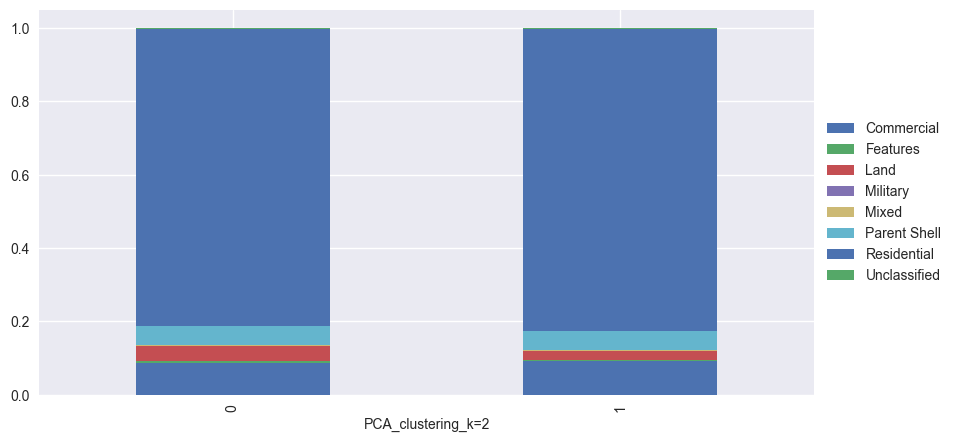


('weekend', 'spring')


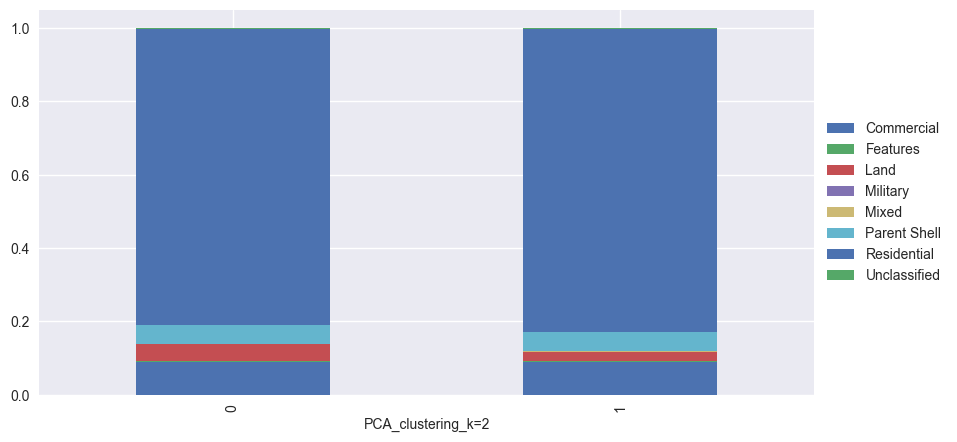


('week', 'summer')


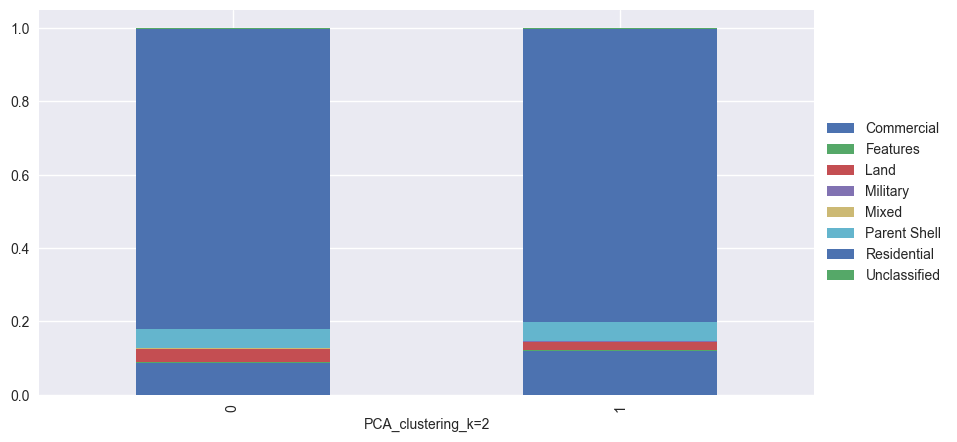


('weekend', 'summer')


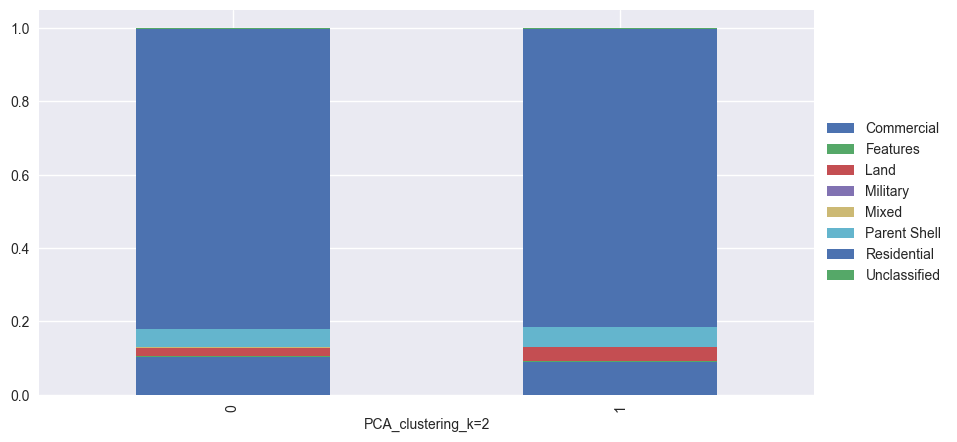


('week', 'fall')


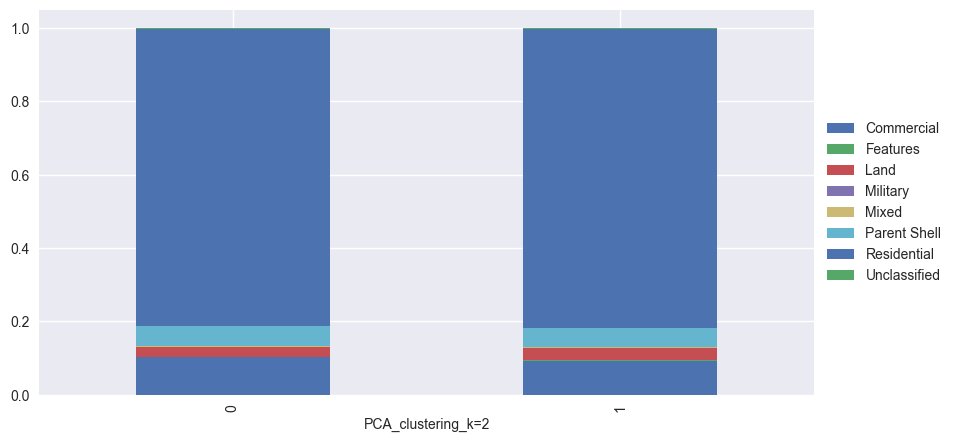


('week', 'winter')


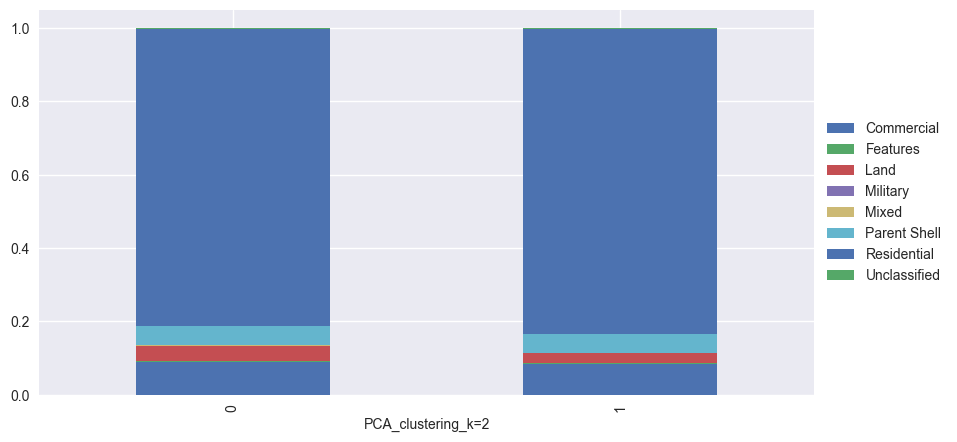


('weekend', 'winter')


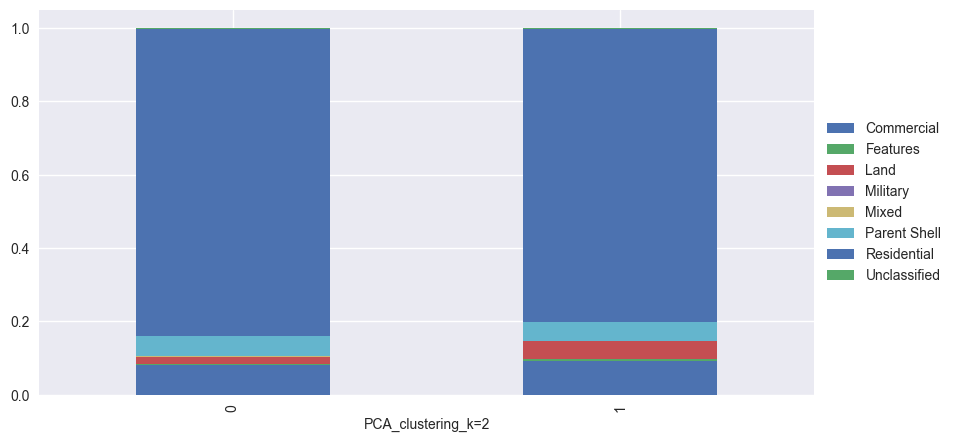


('weekend', 'fall')


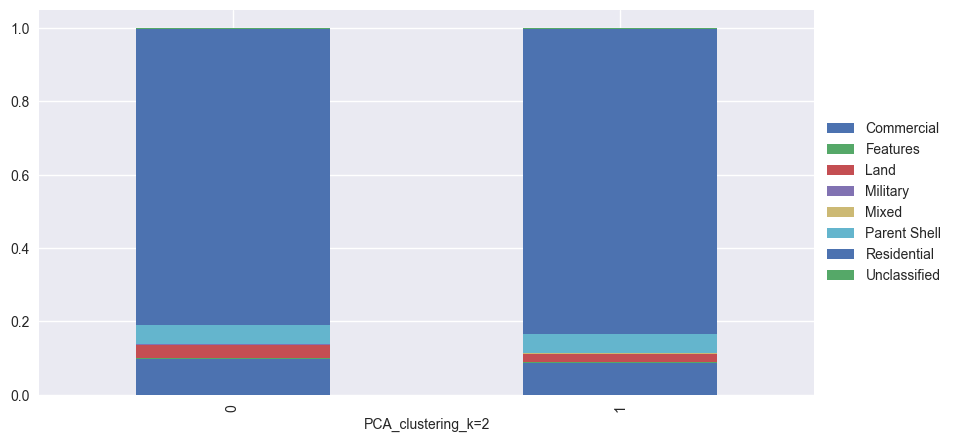

In [240]:
# Iterate through result_dict
for key, df in result_dict_pca.items():
    print(f"\n{key}")
    pd.crosstab(df['PCA_clustering_k=2'], df['Land Uses'], normalize = 'index').plot(kind = 'bar', stacked = True, legend = True, figsize = (10, 5))
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    #another way to plot
    # #df.groupby('cluster_4')['Land Uses'].value_counts(normalize=True).reset_index(name='proportion').plot(kind='bar', x='Land Uses', y='proportion', figsize=(10, 5))

    plt.show()